# **Meflah wided _22214601**

# Notebook Autoencodeur

Dans ce notebook, nous allons mis en place un autoencodeur dans le bit de colorier des images

# **Importer les librairies nécessaires**

---



In [1]:


!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

# eventuellement ne pas oublier de relancer le kernel du notebook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 75.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=e8c188a0b3701183b74d179ab9e1fffd095a98c13f86209b9f2b94d4b0a97cae
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are in

In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential

import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import PIL
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
import random
from sklearn.model_selection import StratifiedKFold,train_test_split
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from keras.models import Model
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras import backend as K
from keras.layers import Reshape, Conv2DTranspose
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

## **Installation des libraire et mise en palce de google drive**

In [3]:
!pip install pyyaml h5py #pour sauvegarder le modèle

In [4]:
# pour monter son Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import sys
my_local_drive='/content/gdrive/MyDrive/ML2_prjt2023'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/MyDrive/ML2_prjt2023


'/content/gdrive/MyDrive/ML2_prjt2023'

In [ ]:
import zipfile
with zipfile.ZipFile("Tiger-Fox-Elephant.zip","r") as zip_ref:
    zip_ref.extractall("Data_Project")

# **Définition de quelques fonctions utiles**

---



In [6]:
# Pour trier les fichiers en ordre alphabétique
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

In [7]:
def create_training_data(path_data, list_classes):
  training_data=[]   #Tableau de retour
  for classes in list_classes: # tiger et tiger_negative
      path = os.path.join(path_data, classes)
      class_num = list_classes.index(classes)
      for img in os.listdir(path):
        try:
          img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
          new_array = cv2.resize(img_array, (SIZE,SIZE))
          training_data.append([new_array, class_num])  # on remplit notre tableau
        except Exception as e:
          pass
  return training_data

In [8]:
def create_X_y (path_data, list_classes):
      # récupération des données
      training_data = create_training_data(path_data, list_classes)
      # tri des données
      random.shuffle(training_data)
      # création de X et y
      X=[]
      y=[]
      for features, label in training_data:
        X.append(features)
        y.append(label)
      X=np.array(X).reshape(-1,SIZE, SIZE, 3)  #-1 The new shape should be compatible with the original shape.
      y=np.array(y)
      return X,y

In [9]:
def clean_data(x):
  # convertion d'entier en float
  xtrain_norm = x.astype('float32')
  # normalisation entre 0 et 1
  xtrain_norm = xtrain_norm / 255.0
  return xtrain_norm

# **Préparation des données**

---



In [13]:
from tensorflow.keras.preprocessing.image import img_to_array

SIZE = 128
color_img = []
gray_img = []

#Les chemins vers les dossier de données
path = 'Data_Project/Tiger-Fox-Elephant/tiger'
path2 = 'Data_Project/Tiger-Fox-Elephant/elephant'
path3 = 'Data_Project/Tiger-Fox-Elephant/fox'
files = os.listdir(path)
files = sorted_alphanumeric(files)

files2 = os.listdir(path2)
files2 = sorted_alphanumeric(files2)

files3 = os.listdir(path3)
files3 = sorted_alphanumeric(files3)

#Remplir les tableau color_img et gray_img
for i in tqdm(files):
  img = PIL.Image.open(path + '/'+i)
    #Transformation de l'image en grayscale
  imgGray = img.convert("L")
    #Redimensionner l'image en couleur
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))
    #Redimensionner l'image en noir et blanc
  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))



for i in tqdm(files2):
  img = PIL.Image.open(path2 + '/'+i)
  imgGray = img.convert("L")
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))

  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))




for i in tqdm(files3):
  img = PIL.Image.open(path3 + '/'+i)
  imgGray = img.convert("L")
  img = img.resize((SIZE, SIZE))
  img = np.float32(img) / 255.0
  color_img.append(img_to_array(img))

  imgGray = imgGray.resize((SIZE, SIZE))
  imgGray = np.float32(imgGray)  / 255.0
  gray_img.append(np.squeeze(img_to_array(imgGray)))


100%|██████████| 100/100 [01:26<00:00,  1.15it/s]


In [23]:
my_path = "Data_Project/Tiger-Fox-Elephant/"
my_classes = ['tiger','Tiger_negative_class']
batchSize = 32



def addGenerateddata(Xbatch):
 for i in range (batchSize):
   Xbatch[i] = cv2.cvtColor(Xbatch[i], cv2.COLOR_BGR2RGB)
   imgGray = cv2.cvtColor(Xbatch[i], cv2.COLOR_BGR2GRAY)
   color_img.append(img_to_array(Xbatch[i]))
   gray_img.append(np.squeeze(img_to_array(imgGray)))



X, y = create_X_y(my_path, my_classes)
X = clean_data(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True)

y_train.shape = (y_train.shape[0],1)
y_test.shape = (y_test.shape[0],1)

datagen = ImageDataGenerator(width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               rotation_range=5,
                               fill_mode='nearest')
train_iterator = datagen.flow(X_train, y_train, batch_size= batchSize, shuffle=False, save_prefix='augmente_train')
loop=0
for X_batch, y_batch in train_iterator:
    loop=loop+1
    print('data batch shape:',X_batch.shape)
    print('labels batch shape:',y_batch.shape)
    addGenerateddata(X_batch)

    if(len(color_img)>8000) : break

data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labels batch shape: (32, 1)
data batch shape: (32, 128, 128, 3)
labe

In [14]:

color_img,gray_img = sklearn.utils.shuffle(color_img,gray_img)

In [15]:

len(color_img)

300

**Affichage de l'image en couleur et son image noir et blanc correspondante**

In [24]:

def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Image en couleur', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Image en noir et blanc', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')

    plt.show()

In [ ]:
#Affichage de 7 image aléatoire
for i in range(3,10):
   plot_images(color_img[i],gray_img[i])

In [16]:


train_gray_image = gray_img[20:]
train_color_image = color_img[20:]

test_gray_image = gray_img[:20]
test_color_image = color_img[:20]

train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,1))

train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print("la forme de l'image en couleur(entrainement):",train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,1))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print("la forme de l'image noir et blanc (entrainement):",test_color_image.shape)



la forme de l'image en couleur(entrainement): (280, 128, 128, 3)
la forme de l'image noir et blanc (entrainement): (20, 128, 128, 3)


**Hyperparamètres**

In [17]:
input_shape = (SIZE, SIZE,1)
tailleBatch = 48
kernel_size = 3
latent_dim = 256
nb_epochs=300

In [ ]:
from keras.applications import VGG16

# **Modèle encodeur**

In [18]:
layer_filters = [64, 128, 256]

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# pile de Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# informations de forme nécessaires pour construire le modèle de décodeur
#afin que nous ne fassions pas de calcul manuel
shape = K.int_shape(x)
# générer un vecteur latent
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# modèle d'encodeur instancié
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17147136 (65.41 MB)
Trainable params: 1714713

In [21]:

decoder_input = Input(shape=input_shape, name='decoder_input')
x = decoder_input


layer_filters = [256, 128, 64]

for filters in layer_filters:
    x = Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)


decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


decoder = Model(decoder_input, decoded, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 256)     2560      
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 256)     0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 128)     295040    
                                                                 
 up_sampling2d_1 (UpSamplin  (None, 512, 512, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 512, 512, 64)      7379

In [ ]:

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

autoencoder.summary()

ValueError: ignored

# **Engregistré le modèle**

---



In [ ]:


save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'modele_ae_colorise.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=1.5*0.5e-6)


checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


autoencoder.compile(loss='mse', optimizer='adam',metrics=['accuracy'])



callbacks = [lr_reducer, checkpoint]

In [ ]:
history=autoencoder.fit(np.stack(np.squeeze(train_gray_image)),
                np.stack(train_color_image),
                validation_data=(np.squeeze(test_gray_image), test_color_image),
                epochs=nb_epochs,
                batch_size=tailleBatch,
                callbacks=callbacks)


x_decoded = autoencoder.predict(np.squeeze(test_gray_image))


Epoch 1/300
167/167 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.3809
Epoch 1: val_loss improved from inf to 0.02362, saving model to /content/gdrive/MyDrive/ML2_prjt2023/saved_models/modele_ae_colorise.001.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/167 [==============================] - 145s 775ms/step - loss: 0.0331 - accuracy: 0.3809 - val_loss: 0.0236 - val_accuracy: 0.4022 - lr: 0.0010
Epoch 2/300
167/167 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.4639
Epoch 2: val_loss improved from 0.02362 to 0.01815, saving model to /content/gdrive/MyDrive/ML2_prjt2023/saved_models/modele_ae_colorise.002.h5
167/167 [==============================] - 159s 953ms/step - loss: 0.0192 - accuracy: 0.4639 - val_loss: 0.0181 - val_accuracy: 0.4544 - lr: 0.0010
Epoch 3/300
167/167 [==============================] - ETA: 0s - loss: 0.0160 - accuracy: 0.5093
Epoch 3: val_loss improved from 0.01815 to 0.01594, saving model to /content/gdrive/MyDrive/ML2_prjt2023/saved_models/modele_ae_colorise.003.h5
167/167 [==============================] - 180s 1s/step - loss: 0.0160 - accuracy: 0.5093 - val_loss: 0.0159 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 4/300
167/167 [==============================] - ETA: 0s - loss: 0.0141

Text(0.5, 1.0, 'Courbes de précision')

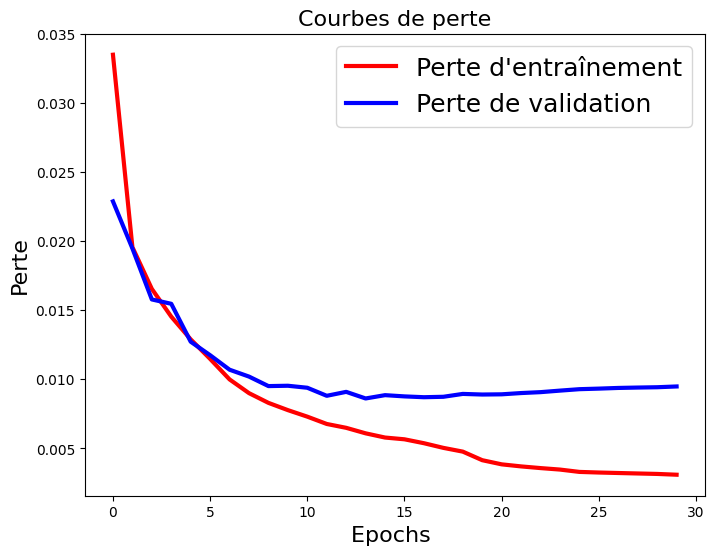

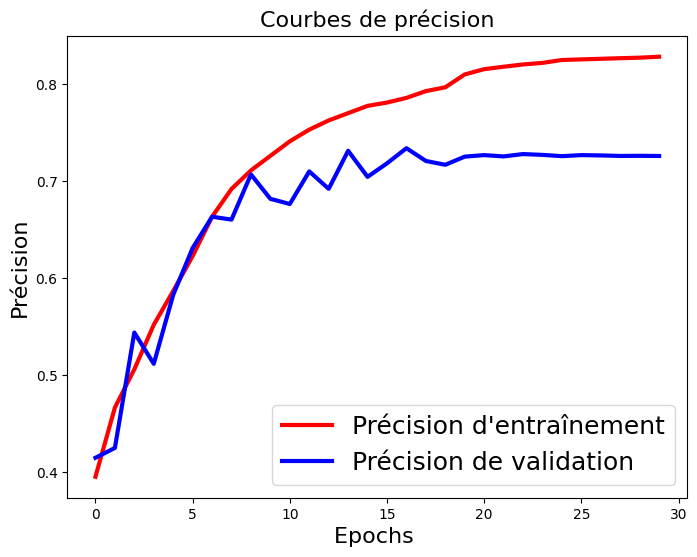

In [ ]:

plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(["Perte d'entraînement", "Perte de validation"],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Perte',fontsize=16)
plt.title('Courbes de perte',fontsize=16)


plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(["Précision d'entraînement", 'Précision de validation'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Précision',fontsize=16)
plt.title('Courbes de précision',fontsize=16)

In [19]:

def ploot(color,grayscale,colorized):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Expected image', color = 'green', fontsize = 20)
    plt.imshow(color)


    plt.subplot(1,3,3)
    plt.title('Colorized image', color = 'blue', fontsize = 20)
    plt.imshow(colorized)
    plt.show()

In [20]:
for i in range(0,19):

     ploot(test_color_image[i],np.squeeze(test_gray_image[i]),x_decoded[i])